**Задание**

**Цель:**

Вспомнить и применить знания, полученные на протяжении всего курса. Получить полноценную работу, объединяющую в себе основные методики по работе с данными и алгоритмы машинного обучения.

**Описание задания:**

В лабораторной работе предлагается решить задачу классификации. Данные для выполнения работы можно скачать по [ссылке](https://archive.ics.uci.edu/ml/datasets/Flags), нажав на Data Folder. В датасете находится информация о флаге и базовых показателях страны. На основе доступной информации решается задача классификации стран по религии. Целевой признак мультиклассовый – religion. Остальные признаки описывают характерные черты флага и самой страны. Подробное описание признаков и их возможные значения можно прочесть на сайте.

In [1]:
# !pip install catboost

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler, normalize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)

# Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)

In [3]:
c = '''    1. name: Name of the country concerned
    2. landmass: 1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania
    3. zone: Geographic quadrant, based on Greenwich and the Equator; 1=NE, 2=SE, 3=SW, 4=NW
    4. area: in thousands of square km
    5. population: in round millions
    6. language: 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others
    7. religion: 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others
    8. bars: Number of vertical bars in the flag
    9. stripes: Number of horizontal stripes in the flag
    10. colours: Number of different colours in the flag
    11. red: 0 if red absent, 1 if red present in the flag
    12. green: same for green
    13. blue: same for blue
    14. gold: same for gold (also yellow)
    15. white: same for white
    16. black: same for black
    17. orange: same for orange (also brown)
    18. mainhue: predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue)
    19. circles: Number of circles in the flag
    20. crosses: Number of (upright) crosses
    21. saltires: Number of diagonal crosses
    22. quarters: Number of quartered sections
    23. sunstars: Number of sun or star symbols
    24. crescent: 1 if a crescent moon symbol present, else 0
    25. triangle: 1 if any triangles present, 0 otherwise
    26. icon: 1 if an inanimate image present (e.g., a boat), otherwise 0
    27. animate: 1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise
    28. text: 1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise
    29. topleft: colour in the top-left corner (moving right to decide tie-breaks)
    30. botright: Colour in the bottom-left corner (moving left to decide tie-breaks)'''
print('Attribute Information:', c, sep='\n\n')

Attribute Information:

    1. name: Name of the country concerned
    2. landmass: 1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania
    3. zone: Geographic quadrant, based on Greenwich and the Equator; 1=NE, 2=SE, 3=SW, 4=NW
    4. area: in thousands of square km
    5. population: in round millions
    6. language: 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others
    7. religion: 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others
    8. bars: Number of vertical bars in the flag
    9. stripes: Number of horizontal stripes in the flag
    10. colours: Number of different colours in the flag
    11. red: 0 if red absent, 1 if red present in the flag
    12. green: same for green
    13. blue: same for blue
    14. gold: same for gold (also yellow)
    15. white: same for white
    16. black: same for black
    17. orange: same for orange (a

In [4]:
columns = [i.strip(':') for i in re.findall('\w+:', c)]
df = pd.read_csv('Data/flag.data', names=columns)
df.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red


# Проведите первичный разведочный анализ данных.

In [5]:
df.describe()

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,3.572165,2.211340,700.046392,23.268041,5.340206,2.190722,0.453608,1.551546,3.463918,0.788660,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,0.170103,0.149485,0.092784,0.149485,1.386598,0.056701,0.139175,0.252577,0.201031,0.082474
std,1.553018,1.308274,2170.927932,91.934085,3.496517,2.061167,1.038339,2.328005,1.300154,0.409315,0.500334,0.501187,0.500334,0.432631,0.444085,0.341556,0.463075,0.385387,0.290879,0.435860,4.396186,0.231869,0.347025,0.435615,0.401808,0.275798
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,471.250000,14.000000,9.000000,4.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,0.000000,0.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,7.000000,5.000000,14.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## a) Проверьте данные на пропуски.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    object
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

Пропуски в данных отсутствуют.

## b) Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака).

[Text(0.5, 1.0, 'Распределение религий по языкам')]

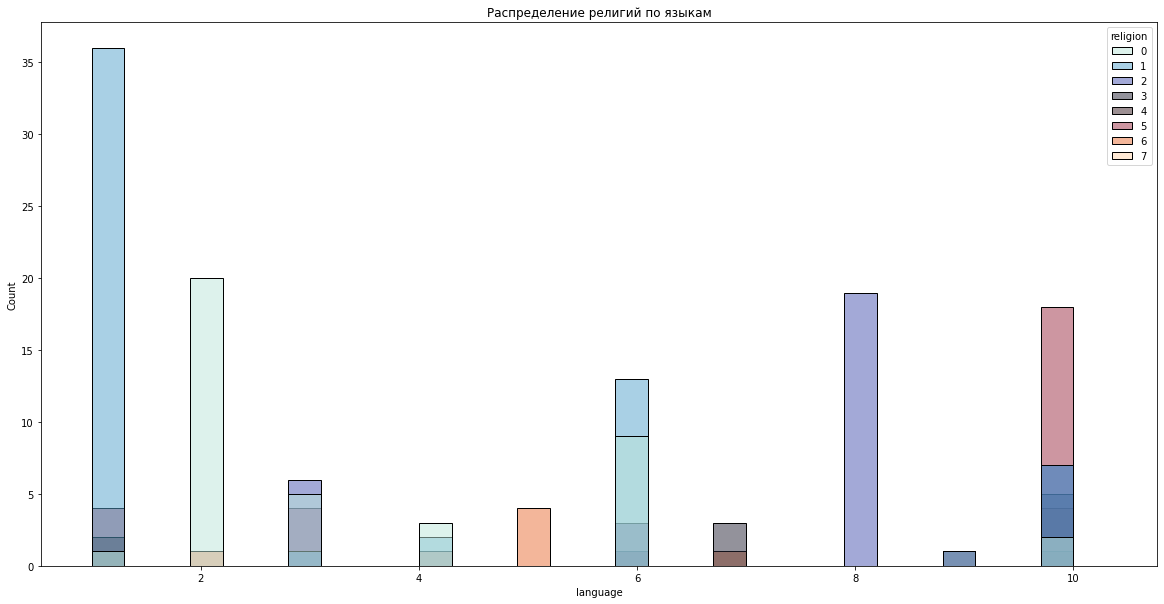

In [7]:
plt.figure(figsize=(20,10))

sns.histplot(data=df, x='language', hue='religion', palette='icefire', bins=10, binwidth=0.3
            ).set(title="Распределение религий по языкам")

Некоторые языки однозначно говорят о религиозной принадлежности.

[Text(0.5, 1.0, 'Распределение религий по географическим зонам')]

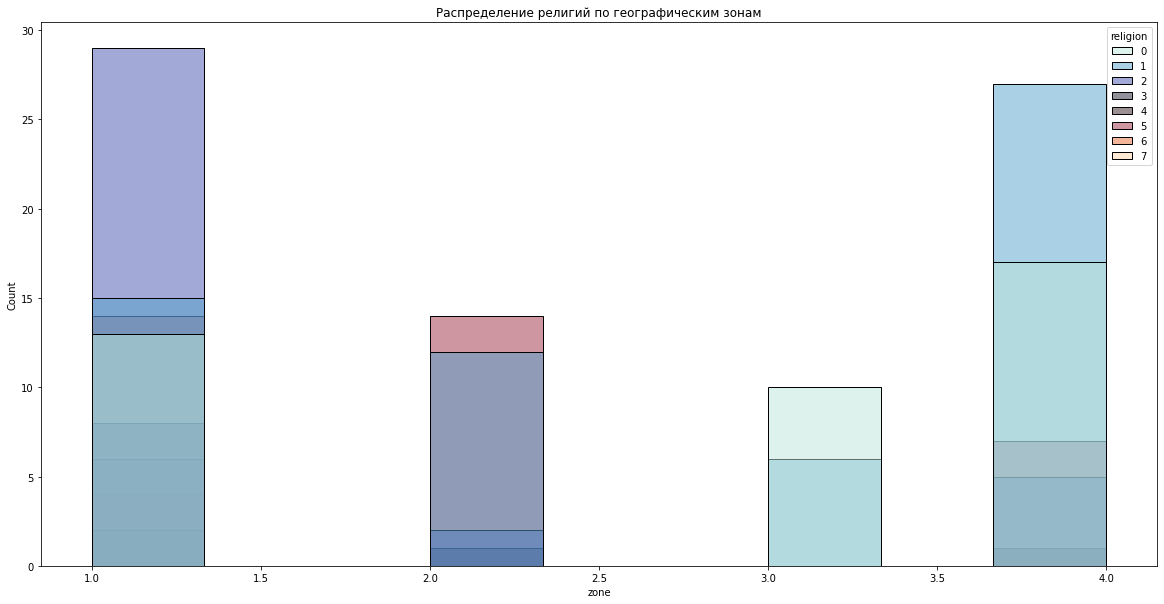

In [8]:
plt.figure(figsize=(20,10))

sns.histplot(data=df, x='zone', hue='religion', palette='icefire').set(title="Распределение религий по географическим зонам")

Видно, что соотношение религий по геозонам различается.

## c) Визуализируйте распределение количества флагов по религиям.

[Text(0.5, 1.0, 'Распределение количества флагов по религиям')]

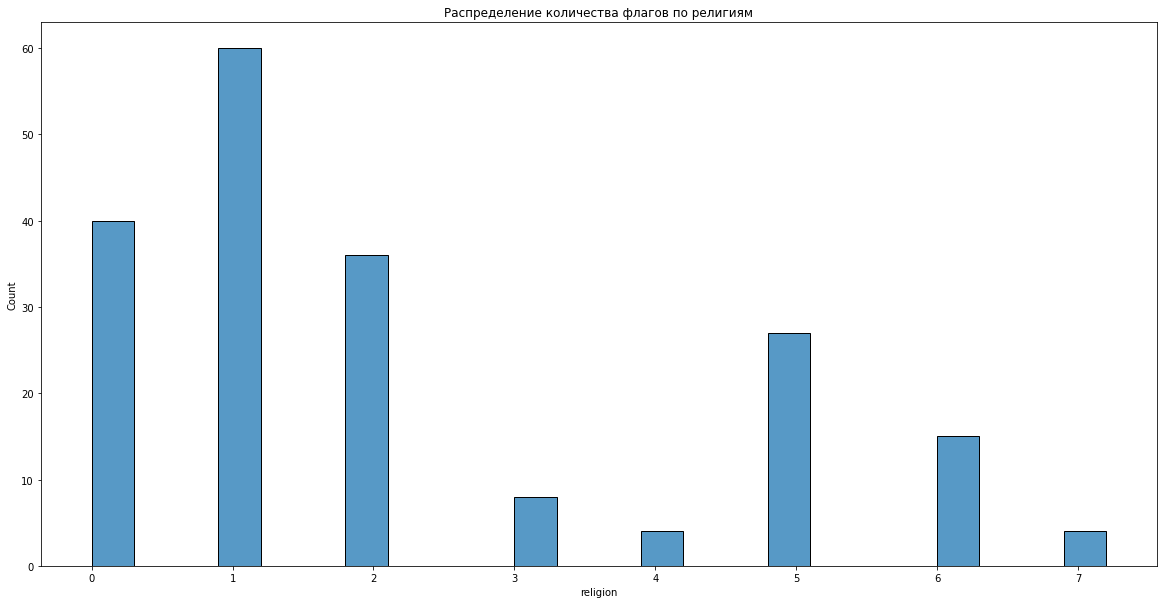

In [9]:
plt.figure(figsize=(20,10))

sns.histplot(data=df, x='religion', bins=8, binwidth=0.3).set(title="Распределение количества флагов по религиям")

В данных имеется выраженный дисбаланс количества флагов по религиям.

# Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

Удалим столбец с названием страны, т.к. он не может влиять на целевую переменную.

In [10]:
X = pd.get_dummies(df.drop(['name', 'religion'], axis=1), drop_first=True)
y = df['religion']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train.shape, y_train.shape

((155, 45), (155,))

# Обучите любую модель классификации на выбор.

In [11]:
%%time
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

CPU times: total: 18.6 s
Wall time: 5.81 s


(1.0, 0.6666666666666666)

# Для тестового множества сделайте предсказание целевой переменной. Выведите метрики модели с помощью [metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). Можно использовать любой другой альтернативный метод подсчета метрик.

In [12]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.82      0.88      0.85        16
           2       0.29      0.50      0.36         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.57      0.67      0.62         6
           6       1.00      0.20      0.33         5

    accuracy                           0.67        39
   macro avg       0.50      0.46      0.44        39
weighted avg       0.69      0.67      0.64        39



# Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.

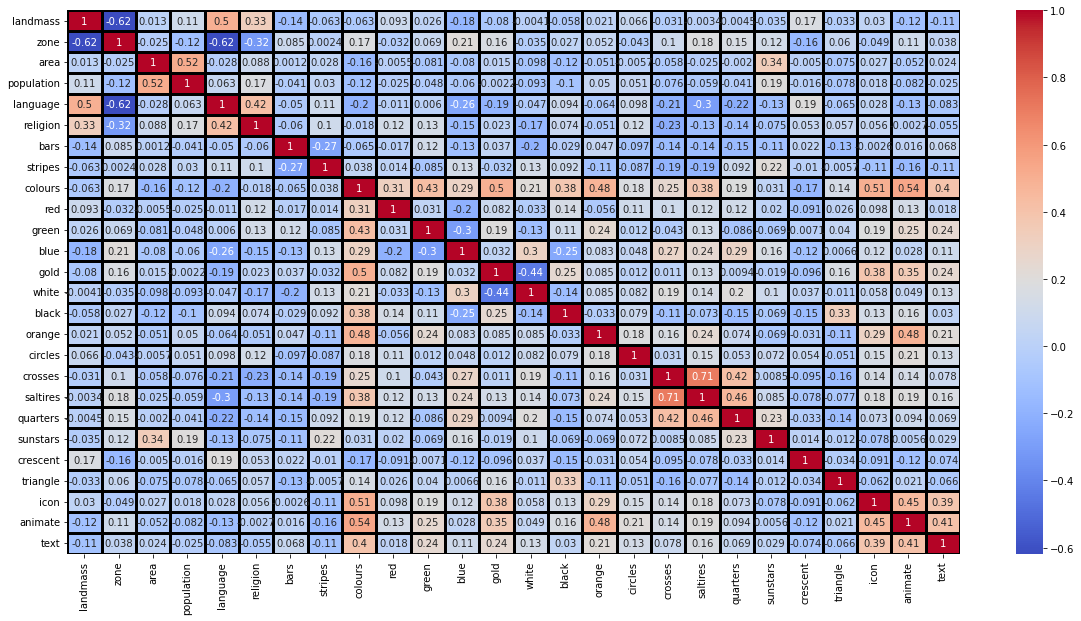

In [13]:
plt.figure(figsize=[20,10])

sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=3, linecolor='black')

plt.show()

## a) Сделайте выводы.

Имеется слабая корреляция признаков landmass и language с целевой переменной, а так же слабая обратная корреляция признака zone с целевой переменной.

# Обработайте выбросы в данных.

## a) Визуализируйте распределение значений для каждой переменной. Можно использовать функции [sns.boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html), [sns.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).

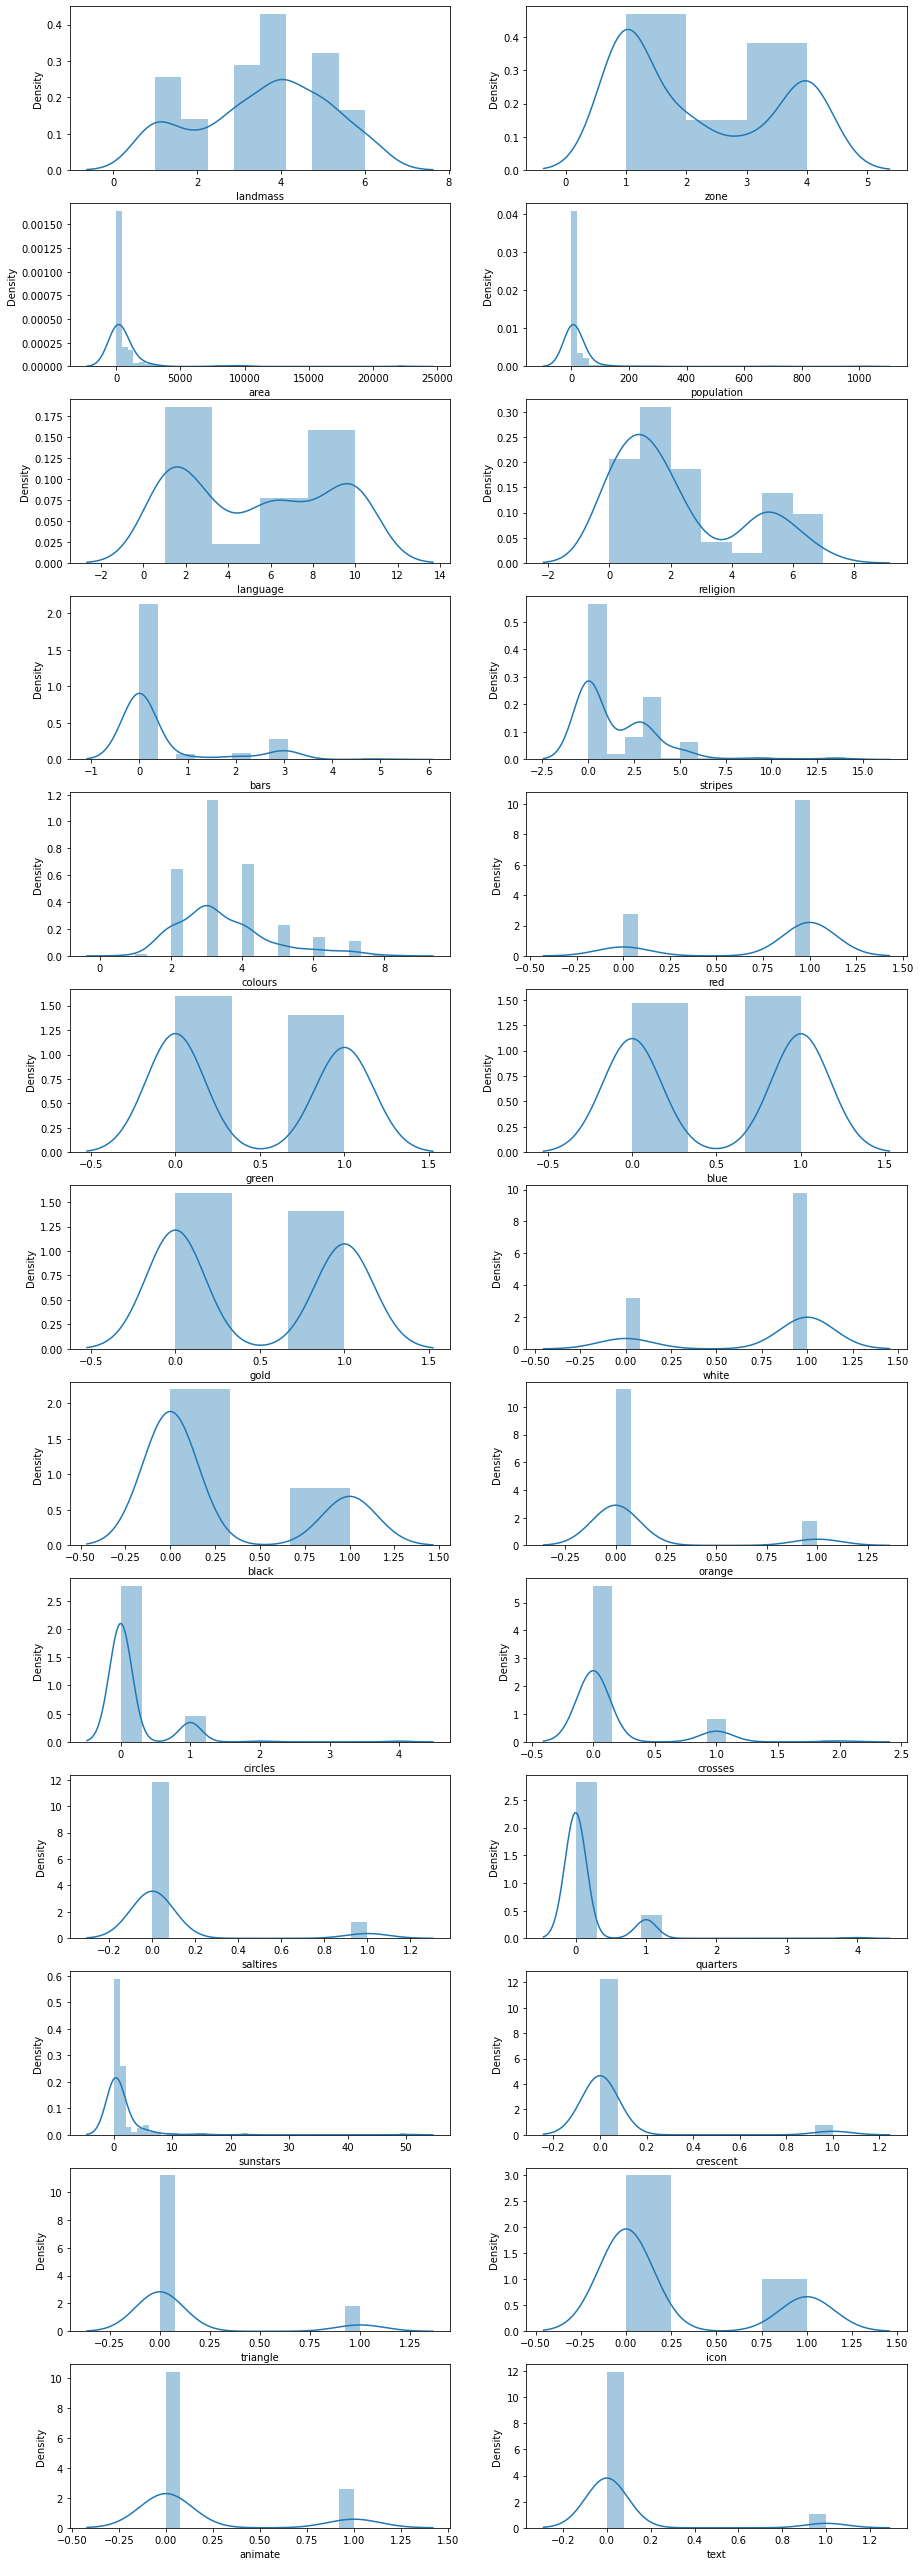

In [14]:
plt.figure(figsize=[15,50])

tmp = df.select_dtypes(include=['int'])
for i, j in zip(tmp.columns, range(len(tmp.columns))):
    plt.subplot(14, 2, j+1)
    sns.distplot(tmp[i])

## b) Исследуйте признаки на выбросы. Удалите выбросы, если они были найдены/вы считаете это необходимым.

In [15]:
def search_outliers(x, limit=0, logs=False):
    classifiers = {
    "OCSVM": OneClassSVM(nu=0.1), # nu - % выбросов
    "IsoForest": IsolationForest(random_state=42, n_jobs=-1),
    "LOF": LocalOutlierFactor(novelty=True, n_jobs=-1),
    "DBSCAN": DBSCAN(eps=6, min_samples=10, n_jobs=-1) # 6/10
    }
    X_tmp = x.copy()
    X_tmp['out'] = 0
    
    for (clf_name, clf) in classifiers.items():
        clf.fit(x)
        if logs:
            print(clf_name)
        if clf_name == 'DBSCAN':
            X_tmp['out'] += clf.labels_
            if logs:
                print(clf.labels_, np.unique(clf.labels_))
        else:
            X_tmp['out'] += clf.predict(x)
            if logs:
                print(clf.predict(x))
        
    X_clast = X_tmp.loc[X_tmp['out'] > limit].copy() # Установив значениe limit можно увеличить или уменьшить число найденных выбросов
    return X_clast

In [16]:
def search_limit(x):
    
    best_limit = None
    best_score = 0

    for lim in range(-3, 2):
        X_clast = search_outliers(x, limit=lim, logs=False)
        data = X_clast.merge(df['religion'], how='left', left_index=True, right_index=True).drop('out', axis=1)

        X_new = data.iloc[:, :-1]
        y_new = data.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, train_size=0.8, random_state=42)

        catboost = CatBoostClassifier(thread_count=-1,
                                      verbose=False,
                                      random_state=42)
        catboost.fit(X_train, y_train)
        score = f1_score(y_test, catboost.predict(X_test), average='weighted')

        if best_score < score:
            best_score = score
            best_limit = lim
        print(f'lim={lim}, Score: {score}')

    print(f'limit={best_limit}, Score: {best_score}')
    return best_limit

In [17]:
X_clast = search_outliers(X, limit=search_limit(X))
X_clast.shape

lim=-3, Score: 0.7041595925297114
lim=-2, Score: 0.6307971014492755
lim=-1, Score: 0.6307971014492755
lim=0, Score: 0.7406031468531469
lim=1, Score: 0.6605475040257649
limit=0, Score: 0.7406031468531469


(159, 46)

In [18]:
data = X_clast.merge(df['religion'], how='left', left_index=True, right_index=True).drop('out', axis=1)
data.head()

,landmass,zone,area,population,language,bars,stripes,colours,red,green,blue,gold,white,black,orange,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,mainhue_blue,mainhue_brown,mainhue_gold,mainhue_green,mainhue_orange,mainhue_red,mainhue_white,topleft_blue,topleft_gold,topleft_green,topleft_orange,topleft_red,topleft_white,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,religion
0,5,1,648,16,10,0,3,5,1,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2
1,3,1,29,3,6,0,0,3,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,6
3,6,3,0,0,1,0,0,5,1,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,3,1,0,0,6,3,0,3,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,4,2,1247,7,10,0,2,3,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5


In [19]:
X_new = data.iloc[:, :-1]
y_new = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, train_size=0.8, random_state=42)

X_train.shape, y_train.shape

((127, 45), (127,))

In [20]:
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

(1.0, 0.75)

In [21]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.90      0.90      0.90        10
           2       0.56      0.83      0.67         6
           3       0.00      0.00      0.00         1
           5       1.00      0.62      0.77         8
           6       0.00      0.00      0.00         2

    accuracy                           0.75        32
   macro avg       0.55      0.56      0.54        32
weighted avg       0.77      0.75      0.74        32



# Проведите нормализацию признаков.

## a) Выберите признаки для нормализации, предложите способы для их обработки.

In [22]:
def log(x):
    '''Логарифмирование'''
    return np.log(x+1e-20) # Добавляем значение, близкое к нулю, для исключение ошибкок при вычислении

In [23]:
def transform_col(x, col, foo, arg):
    '''Применение трансформации к столбцу'''
    if arg == 'normalize':
        x[col] = normalize(x[[col]])
    else:
        x[col] = x[col].apply(foo[arg])
    return x[col]

In [24]:
def search_transform(X, cols=X.columns, flag=False):
    '''Проверка влияния трансформаций на метрику f1-score с учетом кросс-валидации'''
    # Нормализация
    mm_scaler = MinMaxScaler()
    qt = QuantileTransformer()
    s_scaler = StandardScaler()
    
    # Словарь с преобразованиями
    math_transforms = {'nothing': lambda x: x, 'log': log,
                       'min_max_scaler': mm_scaler, 'quantile_transformer': qt,
                       'standart_scaler': s_scaler, 'normalize': normalize}

    for col in cols: # Перебор признаков
        
        best_score = 0
        best_transform = None
        
        for transform in math_transforms.keys(): # Перебор преобразований
                        
            tmp_X = X.copy()
            
            # Разделение нормализации и математических преобразований ввиду различного синтаксиса
            if transform in ['min_max_scaler', 'quantile_transformer', 'standart_scaler']: 
                tmp_X[col] = math_transforms[transform].fit_transform(tmp_X[[col]])
            else:
                tmp_X[col] = transform_col(tmp_X, col, math_transforms, transform)
            
            X_train, X_test, y_train, y_test = train_test_split(tmp_X, y_new, train_size=0.8, random_state=42)

            catboost = CatBoostClassifier(thread_count=-1,
                                         verbose=False,
                                         random_state=42)
            catboost.fit(X_train, y_train)
            score = f1_score(y_test, catboost.predict(X_test), average='weighted')
            
            if best_score < score:
                best_score = score
                best_transform = transform
        
        # Преобразование признаков
        if best_transform in ['min_max_scaler', 'quantile_transformer', 'standart_scaler']:
            X[col] = math_transforms[best_transform].fit_transform(X[[col]])
        else:
            transform_col(X, col, math_transforms, best_transform)
        print(f'{col} - {best_transform}: best_score - {best_score}')
        
    if flag:
        return X

In [25]:
X_new = search_transform(X_new, cols=['landmass', 'zone', 'area', 'population', 'language',
                                      'bars', 'stripes', 'colours', 'sunstars'], flag=True)

landmass - nothing: best_score - 0.7406031468531469
zone - normalize: best_score - 0.7757390635680109
area - nothing: best_score - 0.7757390635680109
population - nothing: best_score - 0.7757390635680109
language - nothing: best_score - 0.7757390635680109
bars - nothing: best_score - 0.7757390635680109
stripes - nothing: best_score - 0.7757390635680109
colours - nothing: best_score - 0.7757390635680109
sunstars - nothing: best_score - 0.7757390635680109


# Повторите п. 4, п. 5.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, train_size=0.8, random_state=42)

X_train.shape, y_train.shape

((127, 45), (127,))

In [27]:
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

(1.0, 0.78125)

In [28]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.89      0.80      0.84        10
           2       0.56      0.83      0.67         6
           3       1.00      1.00      1.00         1
           5       1.00      0.75      0.86         8
           6       0.00      0.00      0.00         2

    accuracy                           0.78        32
   macro avg       0.71      0.73      0.71        32
weighted avg       0.79      0.78      0.78        32



# Сбалансируйте классы путем oversampling/undersampling.

In [29]:
oversampling = SMOTE(sampling_strategy='all', k_neighbors=1, random_state=42, n_jobs=-1)
X_new, y_new = oversampling.fit_resample(X_new, y_new)

<AxesSubplot:xlabel='religion', ylabel='Count'>

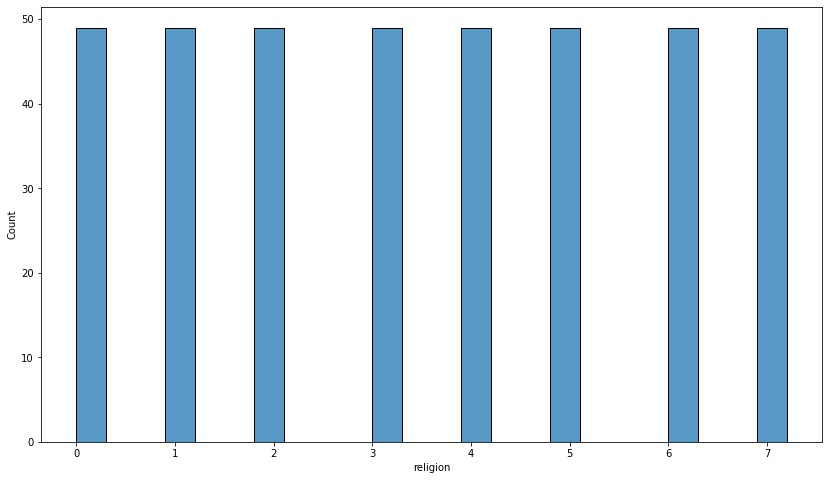

In [30]:
plt.figure(figsize=[14,8])
sns.histplot(y_new, bins=6, binwidth=0.3)

## a) Повторите п. 4, п. 5.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, train_size=0.8, random_state=42)

X_train.shape, y_train.shape

((313, 45), (313,))

In [32]:
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

(1.0, 0.8607594936708861)

In [33]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.80      0.80      0.80        10
           2       0.86      0.67      0.75         9
           3       1.00      0.80      0.89         5
           4       1.00      0.89      0.94         9
           5       0.65      1.00      0.79        13
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00        11

    accuracy                           0.86        79
   macro avg       0.91      0.85      0.87        79
weighted avg       0.89      0.86      0.86        79



# Уменьшите размерность пространства признаков.

In [34]:
X_pca = X_new.copy()
pca = PCA()
X_pca = pca.fit_transform(X_pca)
X_pca = pd.DataFrame(X_pca, columns=X_new.columns)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_new, train_size=0.8, random_state=42)
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
best_score = f1_score(y_test, cbc.predict(X_test), average='macro')
print(best_score)

0.8137385444834364


Метрика снизилась после преобразования. Попробуем найти, какие столбцы не нуждаются в уменьшении размерности.

In [35]:
for col in X_new.columns:
    X_temp = X_pca.copy()
    X_temp.drop(col, axis=1, inplace=True)
    X_temp[col] = X_new[col]
    
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_new, train_size=0.8, random_state=42)

    catboost = CatBoostClassifier(thread_count=-1,
                                 verbose=False,
                                 random_state=42)
    catboost.fit(X_train, y_train)
    score = f1_score(y_test, catboost.predict(X_test), average='macro')
            
    if best_score <= score:
        best_score = score
        X_pca.drop(col, axis=1, inplace=True)
        X_pca[col] = X_new[col]
        print(f'{col} not pca')
    print(col, best_score)
X_pca.head()

landmass 0.8137385444834364
zone 0.8137385444834364
area not pca
area 0.822973491251255
population 0.822973491251255
language not pca
language 0.8248736019547009
bars 0.8248736019547009
stripes 0.8248736019547009
colours 0.8248736019547009
red 0.8248736019547009
green not pca
green 0.8297479027722066
blue 0.8297479027722066
gold 0.8297479027722066
white 0.8297479027722066
black 0.8297479027722066
orange 0.8297479027722066
circles 0.8297479027722066
crosses not pca
crosses 0.8404047035480859
saltires 0.8404047035480859
quarters 0.8404047035480859
sunstars 0.8404047035480859
crescent 0.8404047035480859
triangle 0.8404047035480859
icon 0.8404047035480859
animate 0.8404047035480859
text 0.8404047035480859
mainhue_blue 0.8404047035480859
mainhue_brown not pca
mainhue_brown 0.8428695425571529
mainhue_gold 0.8428695425571529
mainhue_green 0.8428695425571529
mainhue_orange 0.8428695425571529
mainhue_red 0.8428695425571529
mainhue_white 0.8428695425571529
topleft_blue 0.8428695425571529
topleft

,landmass,zone,population,bars,stripes,colours,red,blue,gold,white,black,orange,circles,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,mainhue_blue,mainhue_gold,mainhue_green,mainhue_orange,mainhue_red,mainhue_white,topleft_blue,topleft_gold,topleft_green,topleft_orange,topleft_red,topleft_white,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,area,language,green,crosses,mainhue_brown
0,418.472587,-9.657584,-1.186350,2.577834,0.654535,0.056738,-0.571919,0.269975,0.037024,0.109516,-0.066333,0.106462,0.188956,0.258646,0.703538,0.203834,-0.219529,0.473781,0.102749,-0.052108,-0.545922,-0.210614,-0.039167,0.024877,-0.171270,0.281218,-0.209704,0.144692,-0.206330,0.152005,0.206395,0.071729,-0.116285,-0.158547,-0.023487,1.650973e-13,2.925359e-14,-1.534007e-14,-1.852724e-14,5.117141e-14,648,10,1,0,0
1,-200.642968,-3.782761,1.050279,-0.094109,0.746227,-0.287210,-0.546850,-0.585875,0.373474,0.817604,-0.809694,0.550656,0.197405,0.038945,-0.190876,-0.080262,0.298781,-0.044434,-0.301678,-0.032943,0.009637,-0.057277,0.340536,-0.065707,-0.039890,-0.019145,-0.078290,-0.137216,-0.025113,-0.346901,0.022822,0.043163,-0.098551,0.077088,0.110386,2.822855e-12,-5.663627e-16,4.335500e-16,4.402380e-16,-1.223212e-15,29,6,0,0,0
2,-229.734948,-6.123054,1.291418,2.694389,-1.468922,-0.287316,2.580780,-1.227146,0.449623,-0.175638,-0.068154,0.641485,-0.034735,0.395002,0.902768,0.036364,0.215039,-0.478827,-0.618982,-0.200501,0.346451,-0.124221,-0.097602,0.369084,-0.034308,-0.244534,0.135119,0.315981,0.255445,-0.276431,0.010784,-0.001699,-0.097987,-0.061919,-0.084078,-9.715382e-15,3.954623e-14,-1.640607e-14,-1.298145e-14,-7.083793e-15,0,1,0,0,0
3,-229.720684,-5.898120,0.449492,-0.583235,1.117999,2.487866,0.467466,-1.102713,0.387454,0.149992,0.664904,-0.174933,-0.318270,0.243676,-0.238058,-0.302344,0.378045,-0.036751,-0.028297,0.238747,-0.024450,0.088737,0.107517,0.268605,-0.050149,0.107734,0.009835,0.006050,-0.027877,-0.018044,-0.208089,0.071002,0.233873,-0.145604,0.034728,2.661061e-14,-4.263968e-14,-2.168517e-14,-2.651276e-15,-3.778048e-15,0,6,0,0,0
4,1016.913688,-37.029340,-0.494763,0.217681,0.499991,-0.553051,-0.301801,-0.039828,0.522862,1.261618,-0.868278,-0.283794,-0.340872,0.084274,0.211496,0.023487,-0.592653,0.146657,0.150597,-0.151520,-0.163260,-0.173784,-0.070463,-0.117142,0.030603,0.152136,0.114403,0.101939,-0.010442,-0.047120,-0.058531,-0.018204,-0.051163,-0.098894,-0.004384,-5.071142e-14,1.884806e-14,-3.383099e-14,-4.883406e-14,2.079091e-15,1247,10,0,0,0


## a) Повторите п. 4, п. 5.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_new, train_size=0.8, random_state=42)

X_train.shape, y_train.shape

((313, 45), (313,))

In [37]:
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

(1.0, 0.8481012658227848)

In [38]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.69      0.90      0.78        10
           2       0.88      0.78      0.82         9
           3       1.00      0.80      0.89         5
           4       1.00      0.89      0.94         9
           5       0.75      0.92      0.83        13
           6       0.75      0.60      0.67         5
           7       1.00      1.00      1.00        11

    accuracy                           0.85        79
   macro avg       0.87      0.83      0.84        79
weighted avg       0.86      0.85      0.85        79



# Примените любой метод на ваше усмотрение для отбора признаков.

In [39]:
def scoring_sfs_estimators(X, y, logs=False):
    '''Функция перебирает число признаков и подбирает максимальное значение f1-score'''
    sfs_score = 0

    estimator = CatBoostClassifier(thread_count=-1,
                                    verbose=False,
                                    random_state=42)
    for n_feature in range(2, 11):
        selector = SequentialFeatureSelector(estimator=estimator, n_features_to_select=n_feature, n_jobs=-1)
        X_tmp = selector.fit_transform(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_tmp, y, train_size=0.8, random_state=42)
        tmp_score = f1_score(y_test, estimator.fit(X_train, y_train).predict(X_test), average='macro')
        if logs: # логи
            print(estimator, n_feature, tmp_score)
        if tmp_score > sfs_score: # замена значений, при большем accuracy
            sfs_score = tmp_score
            best_est = estimator
            n_features = n_feature
            sfs_features =  selector.get_feature_names_out()
    print(f'{best_est}, n_features={n_features} - score {sfs_score}') # вывод лучшего результата
    
    return sfs_score, sfs_features # возвращает f1-score и features

In [40]:
%%time
sfs_score, sfs_features = scoring_sfs_estimators(X_pca, y_new, logs=True)
sfs_score, list(sfs_features)

<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 2 0.6886374521072798
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 3 0.7444679639532581
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 4 0.7451369903283653
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 5 0.7546301415302964
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 6 0.826327603361264
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 7 0.8436227570738442
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 8 0.8634888285024156
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 9 0.8658116185344648
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00> 10 0.8501306114551084
<catboost.core.CatBoostClassifier object at 0x0000017DCB249D00>, n_features=9 - score 0.8658116185344648
CPU times: total: 3min 46s
Wall time: 6h 15min 42s


(0.8658116185344648,
 ['landmass',
  'zone',
  'population',
  'stripes',
  'topleft_blue',
  'area',
  'language',
  'green',
  'crosses'])

In [41]:
X_pca = X_pca[list(sfs_features)]

## a) Повторите п. 4, п. 5. Укажите количество выбранных признаков.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_new, train_size=0.8, random_state=42)

X_train.shape

(313, 9)

In [43]:
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)
cbc.fit(X_train, y_train)
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

(1.0, 0.8734177215189873)

In [44]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.89      0.80      0.84        10
           2       0.86      0.67      0.75         9
           3       0.80      0.80      0.80         5
           4       1.00      0.89      0.94         9
           5       0.72      1.00      0.84        13
           6       1.00      0.80      0.89         5
           7       0.92      1.00      0.96        11

    accuracy                           0.87        79
   macro avg       0.89      0.85      0.87        79
weighted avg       0.89      0.87      0.87        79



In [45]:
print(f'Число использованных признаков - {X_train.shape[1]}')

Число использованных признаков - 9


# Оптимизируйте параметры модели из п. 4.

In [46]:
cbc = CatBoostClassifier(thread_count=-1,
                        verbose=False,
                        random_state=42)

params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cbc.grid_search(params, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4609753779
bestIteration = 997

0:	loss: 0.4609754	best: 0.4609754 (0)	total: 1.69s	remaining: 49s

bestTest = 0.4372958658
bestIteration = 499

1:	loss: 0.4372959	best: 0.4372959 (1)	total: 3.41s	remaining: 47.8s

bestTest = 0.5128873803
bestIteration = 999

2:	loss: 0.5128874	best: 0.4372959 (1)	total: 5.08s	remaining: 45.8s

bestTest = 0.446570796
bestIteration = 787

3:	loss: 0.4465708	best: 0.4372959 (1)	total: 6.75s	remaining: 43.9s

bestTest = 0.5389281917
bestIteration = 999

4:	loss: 0.5389282	best: 0.4372959 (1)	total: 8.45s	remaining: 42.2s

bestTest = 0.4600305294
bestIteration = 998

5:	loss: 0.4600305	best: 0.4372959 (1)	total: 10.1s	remaining: 40.5s

bestTest = 0.584154766
bestIteration = 999

6:	loss: 0.5841548	best: 0.4372959 (1)	total: 11.8s	remaining: 38.8s

bestTest = 0.4780522327
bestIteration = 998

7:	loss: 0.4780522	best: 0.4372959 (1)	total: 13.5s	remaining: 37.1s

bestTest = 0.6146892571
bestIteration = 999

8:	loss: 0.6146893	best: 0.4372959 (1)

## a) Повторите п. 4, п. 5.

In [47]:
cbc.score(X_train, y_train), cbc.score(X_test, y_test)

(1.0, 0.8734177215189873)

In [48]:
print(classification_report(y_test, cbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.89      0.80      0.84        10
           2       0.78      0.78      0.78         9
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00         9
           5       0.79      0.85      0.81        13
           6       0.80      0.80      0.80         5
           7       0.92      1.00      0.96        11

    accuracy                           0.87        79
   macro avg       0.86      0.86      0.86        79
weighted avg       0.87      0.87      0.87        79



# Обучите стекинг трех моделей, включая модель с оптимизированными параметрами.

In [127]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)),
    ('catboostclassifier', cbc),
    ('KNN', KNeighborsClassifier(n_neighbors=10, n_jobs=-1))
]

In [134]:
stack = StackingClassifier(estimators=estimators)
stack.fit(X_train, y_train)
stack.score(X_train, y_train), stack.score(X_test, y_test)

(1.0, 0.8860759493670886)

In [135]:
print(classification_report(y_test, stack.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.82      0.90      0.86        10
           2       0.75      0.67      0.71         9
           3       0.80      0.80      0.80         5
           4       1.00      0.89      0.94         9
           5       0.75      0.92      0.83        13
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00        11

    accuracy                           0.89        79
   macro avg       0.89      0.86      0.87        79
weighted avg       0.89      0.89      0.89        79



# Выберите результат с лучшими метриками и постройте для него Confusion Matrix.

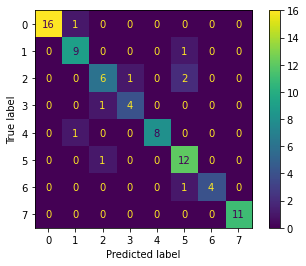

In [136]:
conf_matrix = confusion_matrix(y_test, stack.predict(X_test))

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(8))

cm_display.plot()
plt.show()

# *Творческий пункт. Предложите что-то интересное для датасета.

По столбцу с названием стран можно получить географические координаты столиц, сделать кластеризацию по этим координатам и метки кластеров добавить в датасет.

# Сделайте выводы.

Лучший результат показал стекинг из алгоритмов случайного леса, градиентного бустинга(реализация CatBoostClassifier) и KNN при использовании 9 признаков - 'landmass', 'zone', 'population', 'stripes', 'topleft_blue', 'area', 'language', 'green', 'crosses'. В целом получены достаточно хорошие метрики - **accuracy = 0.89**, **f1_score(macro)=0.87**. Генерация новых признаков может помочь улучшить результат.